In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal
import rasterio

import warnings
warnings.filterwarnings('ignore')

In [2]:
band2 = 'data_10m/bands/T42TXK_20200913T060641_B02_10m.jp2'
band3 = 'data_10m/bands/T42TXK_20200913T060641_B03_10m.jp2'
band4 = 'data_10m/bands/T42TXK_20200913T060641_B04_10m.jp2'
band8 = 'data_10m/bands/T42TXK_20200913T060641_B08_10m.jp2'

In [3]:
band2 = gdal.Open(band2)
band3 = gdal.Open(band3)
band4 = gdal.Open(band4)
band8 = gdal.Open(band8)

In [4]:
blue = band2.ReadAsArray(buf_type=gdal.GDT_Float32)
green = band3.ReadAsArray(buf_type=gdal.GDT_Float32)
red = band4.ReadAsArray(buf_type=gdal.GDT_Float32)
nir = band8.ReadAsArray(buf_type=gdal.GDT_Float32)

In [5]:
def cal_veg_ind(red, nir, blue=None, green=None, key='ndvi'):    
    if key == 'ndvi':
        ndvi = np.where(nir + red == 0., 0.,
                        (nir - red) / (nir + red))
        return ndvi
    
    elif key == 'evi':
        evi = np.where(nir + 6*red -7.5*blue + 1 == 0., 0.,
                      2.5 *(nir - red) / (nir + 6*red -7.5*blue + 1))
        return evi
    
    elif key == 'gndvi':
        gndvi = np.where(nir + green == 0., 0.,
                        (nir - green) / (nir + green))
        return gndvi
    
    elif key == 'cvi':
        cvi = np.where(green == 0., 0.,
                      (nir / green)  * (red / green))
        return cvi

In [6]:
def plot(data, title, cmp=None):
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    ax.imshow(data, cmap=cmp)
    ax.axis('off')
    ax.set_title(title)

In [7]:
ndvi = cal_veg_ind(red=red, nir=nir)
evi = cal_veg_ind(red=red, nir=nir, blue=blue, key='evi')
gndvi = cal_veg_ind(red=None, nir=nir, green=green, key='gndvi')
cvi = cal_veg_ind(red=red, nir=nir, green=green, key='cvi')

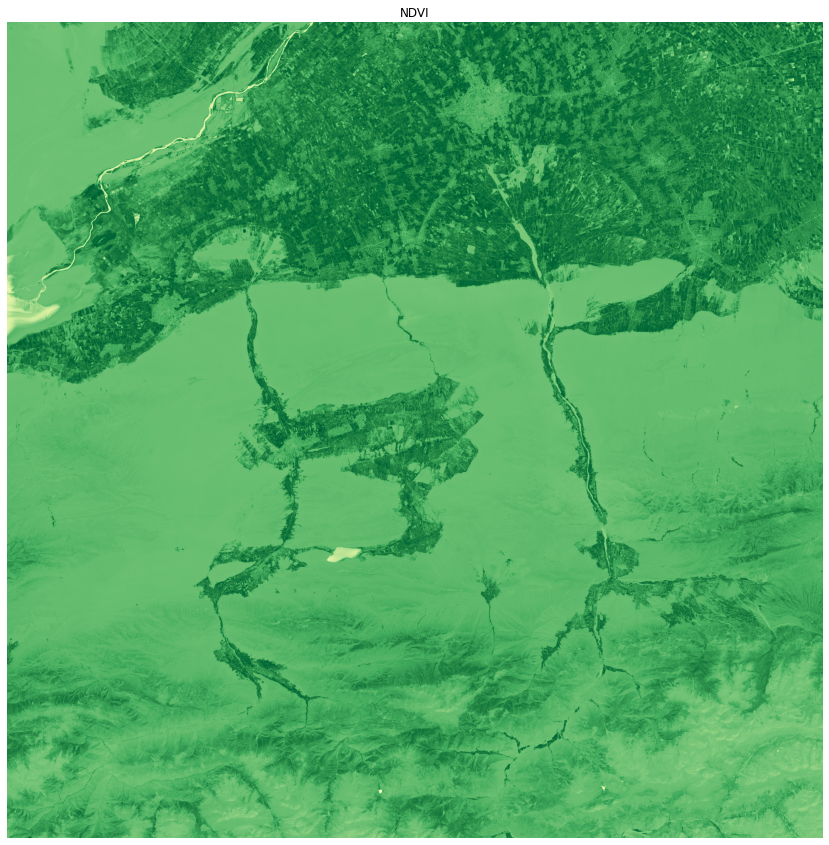

In [8]:
plot(ndvi, 'NDVI', 'YlGn')

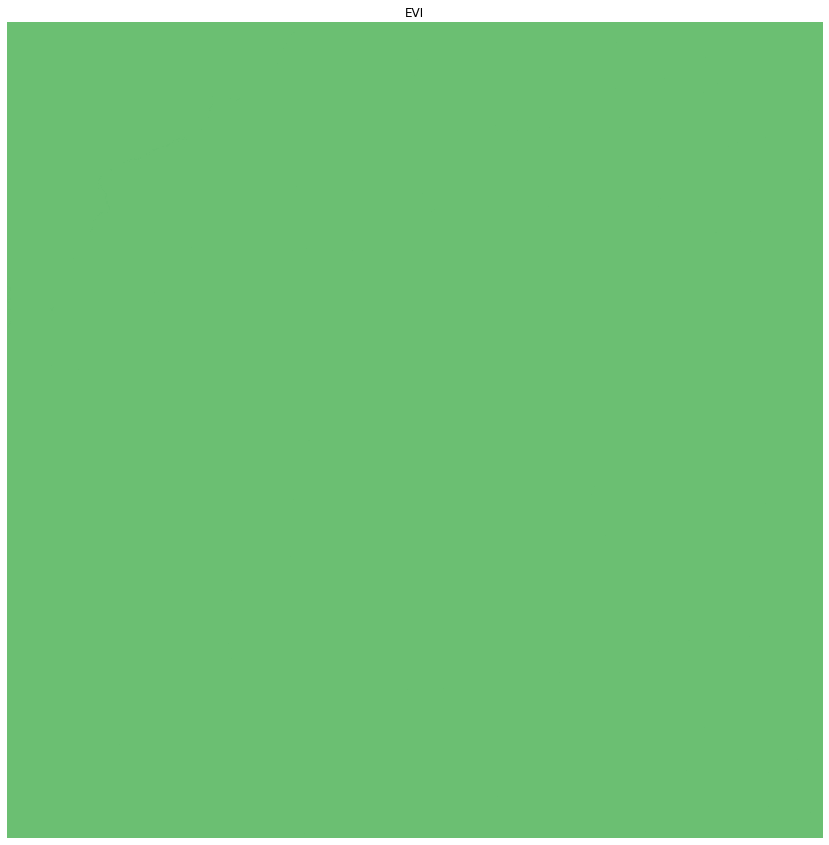

In [9]:
plot(evi, 'EVI', 'YlGn')

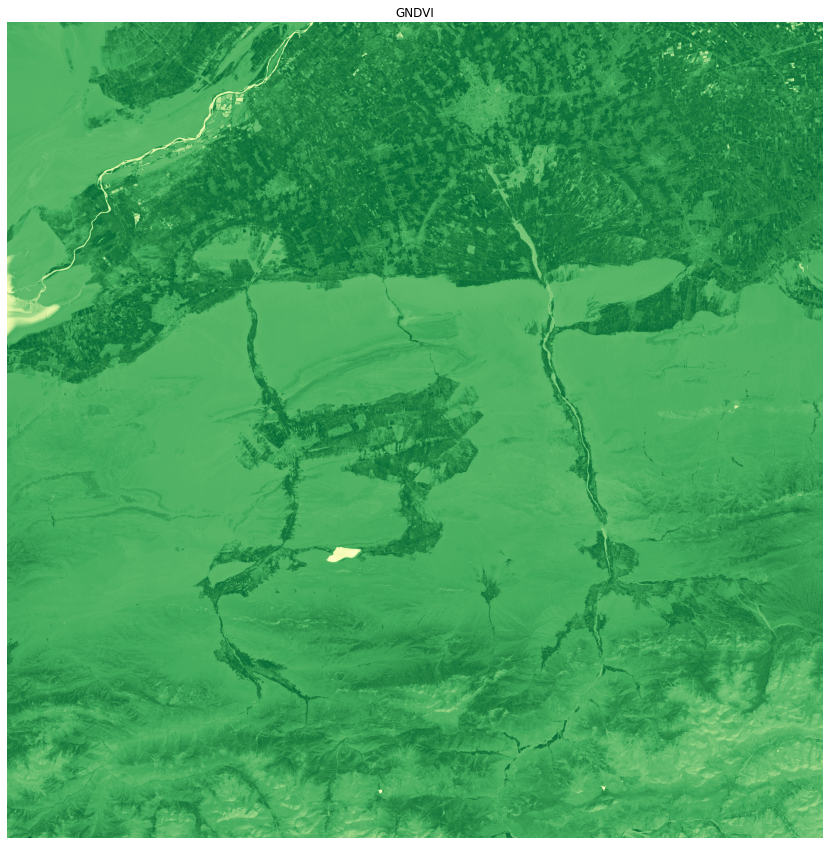

In [10]:
plot(gndvi, 'GNDVI', 'YlGn')

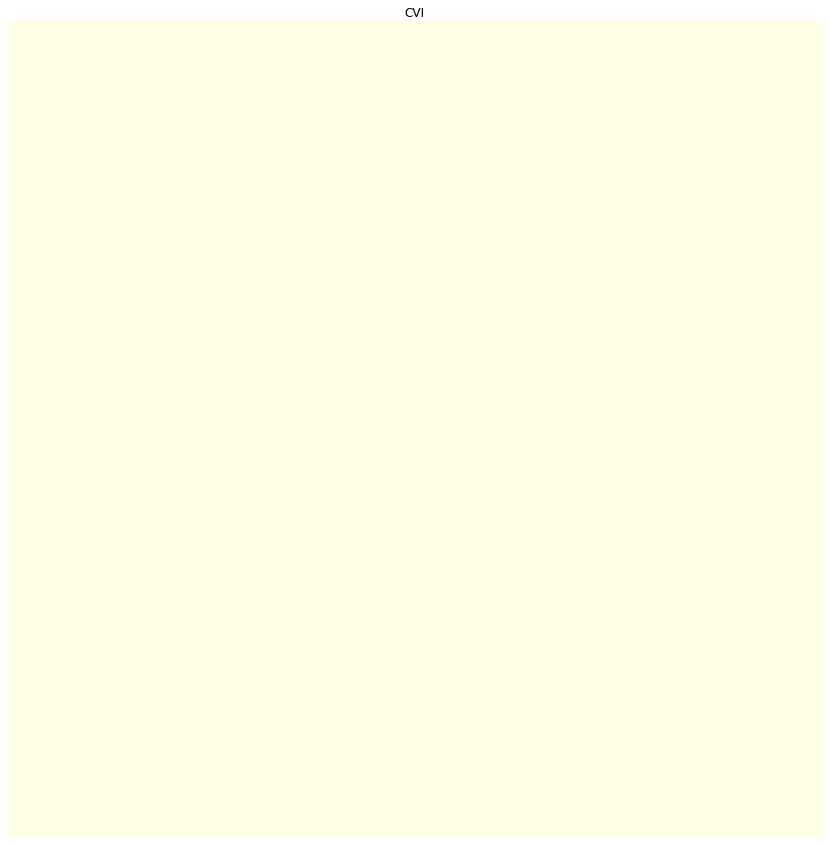

In [11]:
plot(cvi, 'CVI', 'YlGn')

In [95]:
def save_raster(set_data, cr_data, outpath):
    rasterset = gdal.GetDriverByName('GTiff').Create(
        outpath, cr_data.RasterXSize, cr_data.RasterYSize,
        1, gdal.GDT_Float32)
    rasterset.SetProjection(cr_data.GetProjection())
    rasterset.SetGeoTransform(cr_data.GetGeoTransform())
    rasterset.GetRasterBand(1).WriteArray(set_data)
    rasterset.GetRasterBand(1).SetNoDataValue(-999)
    rasterset = None

In [96]:
ndvi_outpath = 'data_10m/layers/NDVI.tiff'
evi_outpath = 'data_10m/layers/EVI.tiff'
gndvi_outpath = 'data_10m/layers/GNDVI.tiff'
cvi_outpath = 'data_10m/layers/CVI.tiff'

In [97]:
save_raster(ndvi, band4, ndvi_outpath)
save_raster(evi, band4, evi_outpath)
save_raster(gndvi, band4, gndvi_outpath)
save_raster(cvi, band4, cvi_outpath)